In [1]:
#Load Libraries
import numpy as np  # To load numpy
import pandas as pd # To load pandas
import math # To calcuate mathematical problems
import time #To calculate the time that take implement the algorithm
from sklearn.model_selection import train_test_split  # for split arrays or matrices into random train and test subsets   
from sklearn import metrics   # importing metrics from sklearn to findout the performance measures.
from sklearn.svm import SVC# here we are importing svm from sklearn
from sklearn import svm # here we are importing svm from sklearn
import matplotlib.pyplot as plt  #To plot the graphs 

In [2]:
#Load USPS Dataset from HDF5 file
import h5py
usps="usps.h5"
with h5py.File(usps, 'r') as hf: #the dataset fetch in reading format
        train = hf.get('train')
        x_train = train.get('data')[:]
        y_train = train.get('target')[:]
        test = hf.get('test')
        x_test = test.get('data')[:]
        y_test = test.get('target')[:]

In [3]:
x_train#Display the elements of x_train set

array([[0.    , 0.    , 0.    , ..., 0.    , 0.    , 0.    ],
       [0.    , 0.    , 0.    , ..., 0.1645, 0.086 , 0.    ],
       [0.    , 0.    , 0.    , ..., 0.    , 0.    , 0.    ],
       ...,
       [0.    , 0.    , 0.    , ..., 0.    , 0.    , 0.    ],
       [0.    , 0.    , 0.    , ..., 0.    , 0.    , 0.    ],
       [0.    , 0.    , 0.    , ..., 0.    , 0.    , 0.    ]],
      dtype=float32)

In [4]:
y_train#Display the elements of y_train set

array([6, 5, 4, ..., 3, 0, 1])

In [5]:
x_test #Display the elements of y_test set

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [6]:
y_test #Display the elements of y_test set

array([9, 6, 3, ..., 4, 0, 1])

In [7]:
#Concatenate training and test set
usps_x=np.row_stack((x_train,x_test))
usps_y=np.append(y_train,y_test)
print('usps_x: ' + str(usps_x.shape)) #Total size of the dataset when we concatenate both training and test set
print('usps_y: ' + str(usps_y.shape))

usps_x: (9298, 256)
usps_y: (9298,)


In [8]:
#Initially complete dataset split into 2,the training set size=20% and the rest are test size =0.80
x_train, x_test, y_train, y_test = train_test_split(usps_x, usps_y, random_state=0,test_size=0.80)
print('X_train: ' + str(x_train.shape))
print('Y_train: ' + str(y_train.shape))
print('X_test:  '  + str(x_test.shape))
print('Y_test:  '  + str(y_test.shape))
print("Training Proper Size:", len(x_train))
print("Other Data Samples:",len(x_test))

X_train: (1859, 256)
Y_train: (1859,)
X_test:  (7439, 256)
Y_test:  (7439,)
Training Proper Size: 1859
Other Data Samples: 7439


In [9]:
from sklearn import metrics
svc_mode1 = SVC()
svc_mode1.fit(x_train, y_train)
y_pred = svc_mode1.predict(x_test)
print("Accuracy of SVM :",metrics.accuracy_score(y_test,y_pred))

Accuracy of SVM : 0.9546982121252856


In [10]:
def set_p_value(x_train, x_test, y_train, y_test, smooth,mode=1):
    p_values=np.zeros((len(x_test),len(set(y_train))))
    on_x_train=x_train.copy()
    on_y_train=y_train.copy()
    on_x_cal=[]
    on_y_cal=[]
    ncs_cal=[]
    svc_mode1=SVC()
    svc_mode1.fit(on_x_train,on_y_train)
    for i in range(len(x_test)):
        dec=svc_mode1.decision_function([x_test[i]])
        if len(on_x_cal)==0:
            #For the first sample set p-values to 1 for every label
            p_values[i]=np.ones(len(set(y_train)))
            on_x_cal=x_test[i].reshape(1,len(x_test[0]))
            on_y_cal=y_test[i]  
        else:
            for j in range(len(set(y_train))):
                con_score=np.append(ncs_cal,(-1*dec[0][j]))
                #Calculate p-values of test sample
                if smooth == False:
                    p_values[i][j]=np.mean(con_score>=con_score[-1])
                else:
                    tau=np.random.uniform()
                    p_values[i][j]=(np.sum(con_score>con_score[-1])+(tau*(np.sum(con_score==con_score[-1]))))/len(con_score)
            on_x_cal=np.row_stack((on_x_cal,x_test[i]))
            on_y_cal=np.append(on_y_cal,y_test[i])    
        ncs_cal=np.append(ncs_cal,-1*dec[0][y_test[i]])
        if len(on_x_cal) > 1000:
            if mode == 2 :
                #If the size of the calibration set is greater than 1000, add all samples to the training set
                on_x_train=np.row_stack((on_x_train,on_x_cal))
                on_y_train=np.append(on_y_train,on_y_cal)
                on_x_cal=[]
                on_y_cal=[]
                ncs_cal=[]
                #Re-fit the SVM on new training set
                svc_mode1.fit(on_x_train,on_y_train)
            if  mode == 3 :
                #If calibration set size is greater than 1000, tranfer 800 samples to training set and leave 200 in calibration set
                on_x_train=np.row_stack((on_x_train,on_x_cal[:len(on_x_cal)-200]))
                on_y_train=np.append(on_y_train,on_y_cal[:len(on_y_cal)-200])
                on_x_cal=on_x_cal[len(on_x_cal)-200:]
                on_y_cal=on_y_cal[len(on_y_cal)-200:]
                #Re-fit SVM to new training set
                svc_mode1.fit(on_x_train,on_y_train)
                #Re-calculate calibration set scores
                dec_cal=svc_mode1.decision_function(on_x_cal)
                row=np.arange(0,len(dec_cal))
                score_cal=-1*dec_cal[row,on_y_cal]
    return p_values,x_test,y_test

In [11]:
def error_multiple_empty(x_test,y_test,significance_level,p_values):
    error=0
    multiple=0
    empty=0
    error_array=np.zeros(len(x_test))
    multiple_array=np.zeros(len(x_test))
    empty_array=np.zeros(len(x_test))
    prediction_set=[0] * len(x_test)
    for i in range(len(x_test)):
        prediction_set[i]=list(np.where(p_values[i]>(significance_level))[0])
        if y_test[i] not in prediction_set[i]:
            error+=1
        if len(prediction_set[i]) > 1:
            multiple+=1
        if len(prediction_set[i]) ==0:
            empty+=1
        error_array[i]=error
        multiple_array[i]=multiple
        empty_array[i]=empty    
    plt.plot(range(len(x_test)),error_array)
    plt.plot(range(len(x_test)),multiple_array)
    plt.plot(range(len(x_test)),empty_array)

Text(0.5, 1.0, 'Online SVM Inductive - Significance Level= 20%')

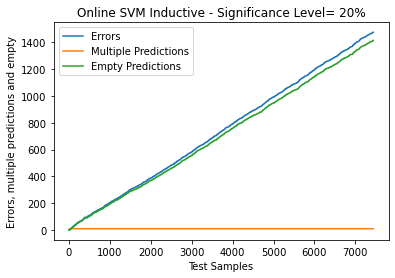

In [12]:
#def mode1(x_test,y_test,significance_level,p_values,x_train, y_train, False):
p_values,x_test, y_test = set_p_value(x_train, x_test, y_train, y_test,False,False)
significance_level=0.20
error_multiple_empty(x_test,y_test,significance_level,p_values)
plt.xlabel("Test Samples")
plt.ylabel("Errors, multiple predictions and empty")
plt.legend(["Errors","Multiple Predictions","Empty Predictions"])
plt.title("Online SVM Inductive - Significance Level= 20%")

Text(0.5, 1.0, 'Online SVM Inductive - Significance Level= 20%')

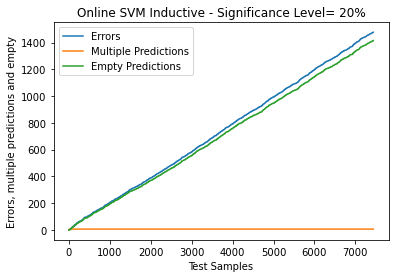

In [13]:
p_values,x_test, y_test = set_p_value(x_train, x_test, y_train, y_test,True)
significance_level=0.20
error_multiple_empty(x_test,y_test,significance_level,p_values)
plt.xlabel("Test Samples")
plt.ylabel("Errors, multiple predictions and empty")
plt.legend(["Errors","Multiple Predictions","Empty Predictions"])
plt.title("Online SVM Inductive - Significance Level= 20%")

Text(0.5, 1.0, 'Online SVM Inductive - Significance Level= 1%')

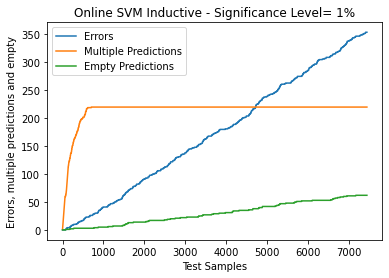

In [14]:
p_values,x_test, y_test = set_p_value(x_train, x_test, y_train, y_test,False)
significance_level=0.05
error_multiple_empty(x_test,y_test,significance_level,p_values)
plt.xlabel("Test Samples")
plt.ylabel("Errors, multiple predictions and empty")
plt.legend(["Errors","Multiple Predictions","Empty Predictions"])
plt.title("Online SVM Inductive - Significance Level= 1%")

Text(0.5, 1.0, 'Online SVM Inductive  - Significance Level= 1%')

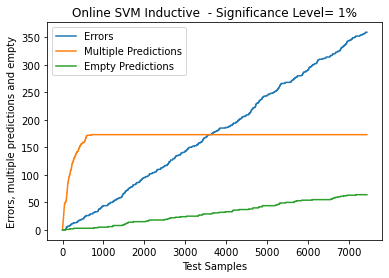

In [15]:
p_values,x_test, y_test = set_p_value(x_train, x_test, y_train, y_test,True)
significance_level=0.05
error_multiple_empty(x_test,y_test,significance_level,p_values)
plt.xlabel("Test Samples")
plt.ylabel("Errors, multiple predictions and empty")
plt.legend(["Errors","Multiple Predictions","Empty Predictions"])
plt.title("Online SVM Inductive  - Significance Level= 1%")

Text(0.5, 1.0, ' Online SVM Mode 1 Validity Curve')

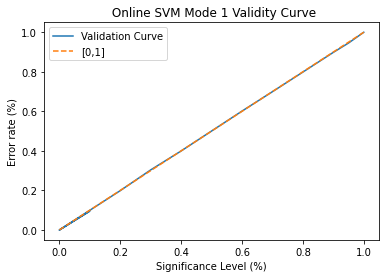

In [16]:
error_rate=[]
sig_level=[0.00001,0.0001,0.001,0.01,0.1,0,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,0.95,1]
for point in sig_level:
    prediction_set=[0] * len(x_test)
    error=0
    for i in range(len(x_test)):
        prediction_set[i]=list(np.where(p_values[i]>(point))[0])
        if y_test[i] not in prediction_set[i]:
            error+=1
    error_rate=np.append(error_rate,error/len(x_test))
plt.plot(sig_level,error_rate)
plt.plot([0,1],[0,1],"--")
plt.legend(["Validation Curve","[0,1]"])
plt.xlabel("Significance Level (%)")
plt.ylabel("Error rate (%)")
plt.title(" Online SVM Mode 1 Validity Curve")

# Mode2

Text(0.5, 1.0, 'Online SVM Inductive - Significance Level= 20%')

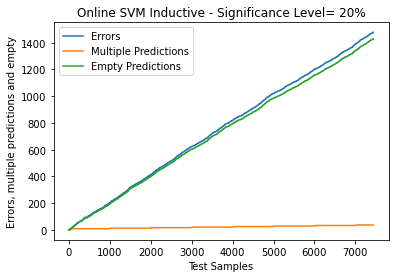

In [17]:
p_values,x_test, y_test = set_p_value(x_train, x_test, y_train, y_test,False,2)
significance_level=0.20
error_multiple_empty(x_test,y_test,significance_level,p_values)
plt.xlabel("Test Samples")
plt.ylabel("Errors, multiple predictions and empty")
plt.legend(["Errors","Multiple Predictions","Empty Predictions"])
plt.title("Online SVM Inductive - Significance Level= 20%")

Text(0.5, 1.0, 'Online SVM Inductive - Significance Level= 20%')

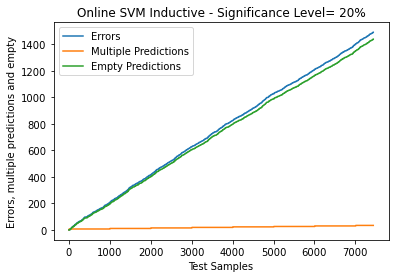

In [18]:
p_values,x_test, y_test = set_p_value(x_train, x_test, y_train, y_test,True,2)
significance_level=0.20
error_multiple_empty(x_test,y_test,significance_level,p_values)
plt.xlabel("Test Samples")
plt.ylabel("Errors, multiple predictions and empty")
plt.legend(["Errors","Multiple Predictions","Empty Predictions"])
plt.title("Online SVM Inductive - Significance Level= 20%")

Text(0.5, 1.0, 'Online SVM Inductive - Significance Level= 1%')

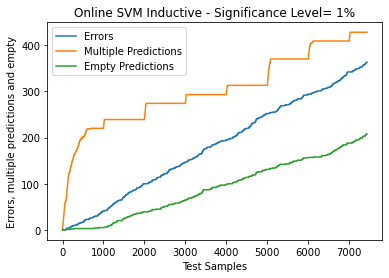

In [19]:
p_values,x_test, y_test = set_p_value(x_train, x_test, y_train, y_test,False,2)
significance_level=0.05
error_multiple_empty(x_test,y_test,significance_level,p_values)
plt.xlabel("Test Samples")
plt.ylabel("Errors, multiple predictions and empty")
plt.legend(["Errors","Multiple Predictions","Empty Predictions"])
plt.title("Online SVM Inductive - Significance Level= 1%")

Text(0.5, 1.0, 'Online SVM Inductive - Significance Level= 1%')

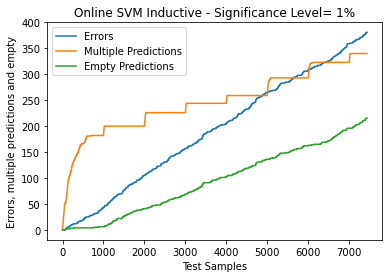

In [20]:
p_values,x_test, y_test = set_p_value(x_train, x_test, y_train, y_test,True,2)
significance_level=0.05
error_multiple_empty(x_test,y_test,significance_level,p_values)
plt.xlabel("Test Samples")
plt.ylabel("Errors, multiple predictions and empty")
plt.legend(["Errors","Multiple Predictions","Empty Predictions"])
plt.title("Online SVM Inductive - Significance Level= 1%")

Text(0.5, 1.0, ' Online SVM Mode 2 Validity Curve')

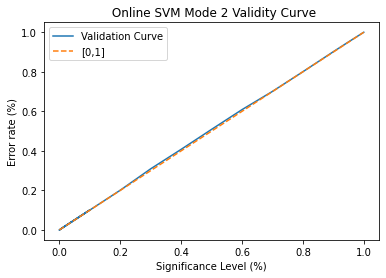

In [21]:
error_rate=[]
sig_level=[0.00001,0.0001,0.001,0.01,0.1,0,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,0.95,1]
for point in sig_level:
    prediction_set=[0] * len(x_test)
    error=0
    for i in range(len(x_test)):
        prediction_set[i]=list(np.where(p_values[i]>(point))[0])
        if y_test[i] not in prediction_set[i]:
            error+=1
    error_rate=np.append(error_rate,error/len(x_test))
plt.plot(sig_level,error_rate)
plt.plot([0,1],[0,1],"--")
plt.legend(["Validation Curve","[0,1]"])
plt.xlabel("Significance Level (%)")
plt.ylabel("Error rate (%)")
plt.title(" Online SVM Mode 2 Validity Curve")

# Mode 3

Text(0.5, 1.0, 'Online SVM Inductive - Significance Level= 20%')

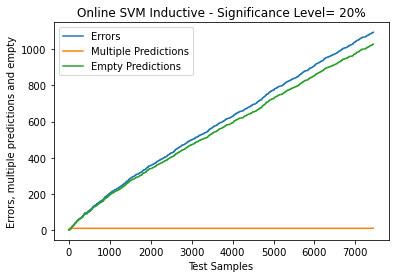

In [22]:
p_values,x_test, y_test = set_p_value(x_train, x_test, y_train, y_test,False,3)
significance_level=0.20
error_multiple_empty(x_test,y_test,significance_level,p_values)
plt.xlabel("Test Samples")
plt.ylabel("Errors, multiple predictions and empty")
plt.legend(["Errors","Multiple Predictions","Empty Predictions"])
plt.title("Online SVM Inductive - Significance Level= 20%")

Text(0.5, 1.0, 'Online SVM Inductive - Significance Level= 20%')

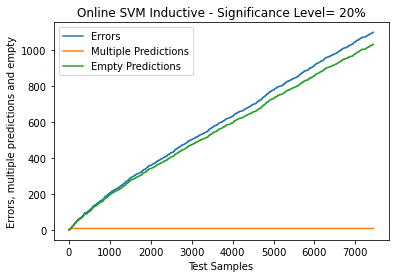

In [23]:
p_values,x_test, y_test = set_p_value(x_train, x_test, y_train, y_test,True,3)
significance_level=0.20
error_multiple_empty(x_test,y_test,significance_level,p_values)
plt.xlabel("Test Samples")
plt.ylabel("Errors, multiple predictions and empty")
plt.legend(["Errors","Multiple Predictions","Empty Predictions"])
plt.title("Online SVM Inductive - Significance Level= 20%")

Text(0.5, 1.0, 'Online SVM Inductive - Significance Level= 1%')

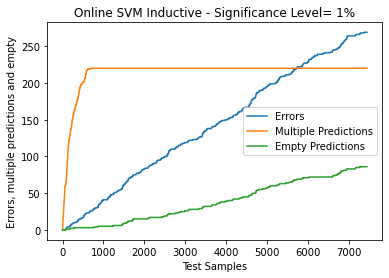

In [24]:
p_values,x_test, y_test = set_p_value(x_train, x_test, y_train, y_test,False,3)
significance_level=0.05
error_multiple_empty(x_test,y_test,significance_level,p_values)
plt.xlabel("Test Samples")
plt.ylabel("Errors, multiple predictions and empty")
plt.legend(["Errors","Multiple Predictions","Empty Predictions"])
plt.title("Online SVM Inductive - Significance Level= 1%")

Text(0.5, 1.0, 'Online SVM Inductive - Significance Level= 1%')

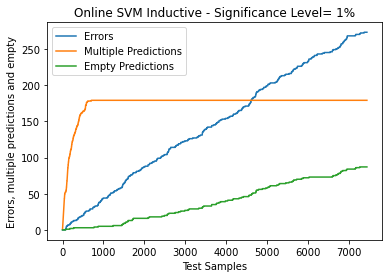

In [25]:
p_values,x_test, y_test = set_p_value(x_train, x_test, y_train, y_test,True,3)
significance_level=0.05
error_multiple_empty(x_test,y_test,significance_level,p_values)
plt.xlabel("Test Samples")
plt.ylabel("Errors, multiple predictions and empty")
plt.legend(["Errors","Multiple Predictions","Empty Predictions"])
plt.title("Online SVM Inductive - Significance Level= 1%")

Text(0.5, 1.0, ' Online SVM Mode 2 Validity Curve')

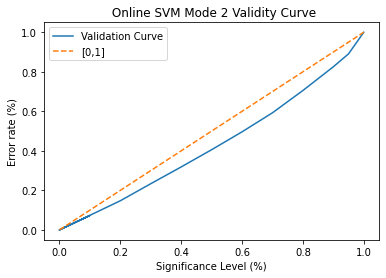

In [26]:
error_rate=[]
sig_level=[0.00001,0.0001,0.001,0.01,0.1,0,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,0.95,1]
for point in sig_level:
    prediction_set=[0] * len(x_test)
    error=0
    for i in range(len(x_test)):
        prediction_set[i]=list(np.where(p_values[i]>(point))[0])
        if y_test[i] not in prediction_set[i]:
            error+=1
    error_rate=np.append(error_rate,error/len(x_test))
plt.plot(sig_level,error_rate)
plt.plot([0,1],[0,1],"--")
plt.legend(["Validation Curve","[0,1]"])
plt.xlabel("Significance Level (%)")
plt.ylabel("Error rate (%)")
plt.title(" Online SVM Mode 2 Validity Curve")